# Model CNN testing

## Carregar les dades

In [1]:
from scipy.io import arff
import pandas as pd
from constants import *

data, _ = arff.loadarff(DATA_DIRECTORY + 'MagicTelescope.arff')
df = pd.DataFrame(data)
df.head(5)

,ID,fLength:,fWidth:,fSize:,fConc:,fConc1:,fAsym:,fM3Long:,fM3Trans:,fAlpha:,fDist:,class:
0,1.0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,b'g'
1,2.0,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,b'g'
2,3.0,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,b'g'
3,4.0,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,b'g'
4,5.0,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,b'g'


## Preparar les Dades per al Model

Ara necessitem:
1. **Separar les característiques (X)** - Són les columnes que el model utilitzarà com entrada (totes menys la classe)
2. **Separar l'objectiu (y)** - És el que volem predir (la columna `class:`)
3. **Dividir en entrenament, validació i prova** - El model aprèn amb entrenament, i mesurem el seu rendiment en prova

    **Per què és important:**
    - **Conjunt de prova**: Mai es fa servir durant l'entrenament o la selecció d'hiperparàmetres (només per a l'avaluació final)
    - **Conjunt de validació**: S'utilitza per afinar hiperparàmetres i prevenir sobreajust
    - **Conjunt d'entrenament**: S'utilitza per entrenar el model

    **Estratègia de divisió:**
    - 60% Entrenament
    - 20% Validació
    - 20% Prova
    - Estratificada per mantenir les proporcions de classes

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Dades i output
X = df.drop(columns=['class:'])
y = df['class:']

# Codificar els possibles outputs
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split 80/20% (train+val/test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)
# Split 75/25% de temp (train/val)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    random_state=42,
    stratify=y_temp
)

print("Dades:", X_train.shape, X_val.shape, X_test.shape)
print("Classes:", y_train.shape, y_val.shape, y_test.shape)

Dades: (11412, 11) (3804, 11) (3804, 11)
Classes: (11412,) (3804,) (3804,)


## Crear y Entrenar el Modelo: Red Neuronal Artificial (ANN)


!!!!!!!!!!!!! Desenvolupar un argument més sòlid !!!!!!!!!!!!!





Vamos a usar una **Red Neuronal Artificial**, que es como una versión inspirada en el cerebro.

**Por qué ANN:**
- Puede aprender patrones complejos y no lineales ✓
- Se adapta bien a datos desbalanceados con `class_weight` ✓
- Más flexible que Random Forest para ciertos problemas ✓
- Podemos visualizar cómo aprende en cada época ✓

**Estructura:**
- Input layer: 10 características (del telescopio)
- Hidden layers: 2 capas ocultas con activación ReLU (aprenden patrones)
- Output layer: 1 neurona con Sigmoid (para clasificación binaria)

**Manejo del desbalance:**
- Usamos `class_weight='balanced'` en el entrenamiento
- Esto hace que el modelo penalice más los errores en la clase minoritaria

In [3]:
import torch
from sklearn.preprocessing import StandardScaler

# Normalitzar les dades
scaler_final = StandardScaler()
X_train_scaled = scaler_final.fit_transform(X_train) # Normalitzem train
X_val_scaled = scaler_final.transform(X_val) # Normalitzem val amb els paràmetres de train
X_test_scaled = scaler_final.transform(X_test) # Normalitzem test amb els paràmetres de train

# Convertir a tensors de torch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcular els pesos de cada classe per evitar desbalanceig
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

for class_label, weight in class_weight_dict.items():
    print(f"  Clase {class_label}: {weight:.4f}")

  Clase 0: 0.7711
  Clase 1: 1.4222


In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleANN(nn.Module):
    def __init__(self, input_dim, hidden_size=5):
        super(SimpleANN, self).__init__()
        # Capa oculta: fully connected
        self.fc1 = nn.Linear(input_dim, hidden_size)  # 5 neuronas en la capa oculta
        # Capa de salida: fully connected
        self.fc2 = nn.Linear(hidden_size, 1)          # 1 neurona para salida binaria

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)   # SIN sigmoid porque ya lo hace el criterion
        return x

In [96]:
def train_model(
        model, criterion, optimizer, X_train_tensor, y_train_tensor,
        X_val_tensor, y_val_tensor, epochs=1000, patience=None, print_progress=True
    ):

    losses = {'train': [], 'val': []}
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Entrenament
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses['train'].append(loss.item())
        
        # Validació
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            losses['val'].append(val_loss.item())
        
        # Early stopping (if patience)
        if patience is not None:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else: patience_counter += 1
            
            if patience_counter >= patience:
                if print_progress: print(f"Early stopping at epoch {epoch}")
                break
        
        if (epoch % (epochs // 10) == 0 or epoch == epochs - 1) and print_progress:
            print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    
    return losses

In [70]:
import matplotlib.pyplot as plt

def plot_training_history(losses_dict, show_best_epoch=False):
    if show_best_epoch:
        pos = losses_dict['val'].index(min(losses_dict['val']))
        print(f"Best epoch: {pos}, Train Loss: {losses_dict['train'][pos]:.4f}, Val Loss: {losses_dict['val'][pos]:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(losses_dict['train'], label='Train Loss', linewidth=2)
    plt.plot(losses_dict['val'], label='Validation Loss', linewidth=2)
    
    if show_best_epoch:
        plt.axvline(x=pos, color='red', linestyle='--', linewidth=2, label='Best Epoch')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Training and Validation Loss Evolution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Epoch 0, Train Loss: 0.7275, Val Loss: 0.7243
Epoch 10000, Train Loss: 0.0041, Val Loss: 0.0068
Epoch 20000, Train Loss: 0.0003, Val Loss: 0.0039
Epoch 30000, Train Loss: 0.0000, Val Loss: 0.0045
Epoch 40000, Train Loss: 0.0000, Val Loss: 0.0030
Epoch 50000, Train Loss: 0.0000, Val Loss: 0.0022
Epoch 60000, Train Loss: 0.0000, Val Loss: 0.0021
Epoch 70000, Train Loss: 0.0000, Val Loss: 0.0022
Epoch 80000, Train Loss: 0.0000, Val Loss: 0.0022
Epoch 90000, Train Loss: 0.0000, Val Loss: 0.0022
Epoch 99999, Train Loss: 0.0000, Val Loss: 0.0022
Best epoch: 55970, Train Loss: 0.0000, Val Loss: 0.0021


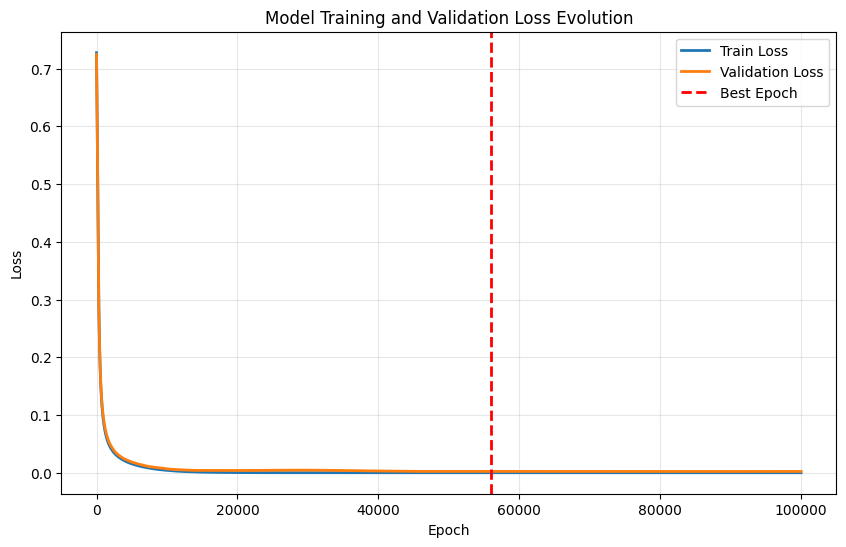

In [74]:
model = SimpleANN(input_dim = X_train_scaled.shape[1])

train_losses_dict = train_model(
    model = model,
    criterion = torch.nn.BCEWithLogitsLoss(),
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001),
    X_train_tensor = X_train_tensor,
    y_train_tensor = y_train_tensor,
    X_val_tensor = X_val_tensor,
    y_val_tensor = y_val_tensor,
    epochs=100000
)

plot_training_history(train_losses_dict, show_best_epoch=True)

In [89]:
impatient_model = SimpleANN(input_dim = X_train_scaled.shape[1])

train_losses_dict = train_model(
    model = impatient_model,
    criterion = torch.nn.BCEWithLogitsLoss(),
    optimizer = torch.optim.Adam(impatient_model.parameters(), lr=0.001),
    X_train_tensor = X_train_tensor,
    y_train_tensor = y_train_tensor,
    X_val_tensor = X_val_tensor,
    y_val_tensor = y_val_tensor,
    epochs=100000,
    patience=50
)

Epoch 0, Train Loss: 0.6471, Val Loss: 0.6459
Early stopping at epoch 9308


El paràmetre paciència sembla funcionar correctament

In [109]:
def plot_accuracy(df):
    plt.figure(figsize=(10, 6))
    plt.plot(df['hidden_size'], df['train_accuracy'], marker='o', label='Train')
    plt.plot(df['hidden_size'], df['test_accuracy'], marker='o', label='Test')
    plt.xscale('log', base=2)
    plt.xlabel('hidden_size')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs hidden_size')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [105]:
complexity_sizes = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]

accuracy_results = []

for hidden_size in complexity_sizes:
    custom_model = SimpleANN(input_dim = X_train_scaled.shape[1], hidden_size=hidden_size)

    train_losses_dict = train_model(
        model = custom_model,
        criterion = torch.nn.BCEWithLogitsLoss(),
        optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.001),
        X_train_tensor = X_train_tensor,
        y_train_tensor = y_train_tensor,
        X_val_tensor = X_val_tensor,
        y_val_tensor = y_val_tensor,
        epochs=1000,
        patience=50,
        print_progress=False
    )

    custom_model.eval()
    with torch.no_grad():
        train_logits = custom_model(X_train_tensor)
        train_probs = torch.sigmoid(train_logits)
        train_preds = (train_probs > 0.5).float()
        train_acc = (train_preds == y_train_tensor).float().mean().item()

        test_logits = custom_model(X_test_tensor)
        test_probs = torch.sigmoid(test_logits)
        test_preds = (test_probs > 0.5).float()
        test_acc = (test_preds == y_test_tensor).float().mean().item()

    accuracy_results.append({
        'hidden_size': hidden_size,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc
    })
    print(f"Hidden Size: {hidden_size}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

accuracy_results_df = pd.DataFrame(accuracy_results)

Hidden Size: 4, Train Accuracy: 0.9794, Test Accuracy: 0.9805
Hidden Size: 8, Train Accuracy: 0.9855, Test Accuracy: 0.9842
Hidden Size: 16, Train Accuracy: 0.9899, Test Accuracy: 0.9879
Hidden Size: 32, Train Accuracy: 0.9912, Test Accuracy: 0.9903
Hidden Size: 64, Train Accuracy: 0.9936, Test Accuracy: 0.9924
Hidden Size: 128, Train Accuracy: 0.9955, Test Accuracy: 0.9926
Hidden Size: 256, Train Accuracy: 0.9968, Test Accuracy: 0.9947
Hidden Size: 512, Train Accuracy: 0.9982, Test Accuracy: 0.9963
Hidden Size: 1024, Train Accuracy: 0.9995, Test Accuracy: 0.9958
Hidden Size: 2048, Train Accuracy: 1.0000, Test Accuracy: 0.9958


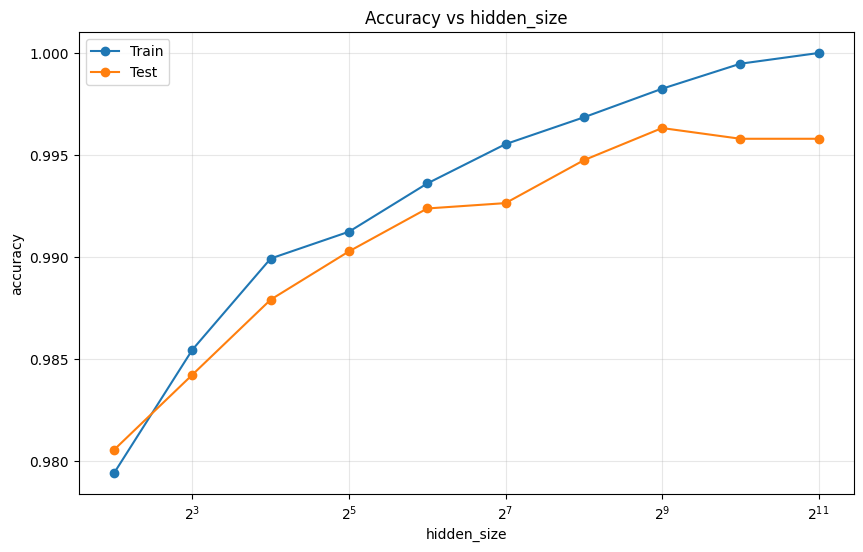

In [110]:
plot_accuracy(accuracy_results_df)

In [111]:
sample_sizes = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.0]
sample_results = []

for size_fraction in sample_sizes:
    n_samples = int(len(X_train_tensor) * size_fraction)
    indices = torch.randperm(len(X_train_tensor))[:n_samples]
    X_train_subset = X_train_tensor[indices]
    y_train_subset = y_train_tensor[indices]

    custom_model = SimpleANN(input_dim = X_train_scaled.shape[1], hidden_size=64)

    train_losses_dict = train_model(
        model = custom_model,
        criterion = torch.nn.BCEWithLogitsLoss(),
        optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.001),
        X_train_tensor = X_train_subset,
        y_train_tensor = y_train_subset,
        X_val_tensor = X_val_tensor,
        y_val_tensor = y_val_tensor,
        epochs=1000,
        patience=50,
        print_progress=False
    )

    custom_model.eval()
    with torch.no_grad():
        train_logits = custom_model(X_train_subset)
        train_probs = torch.sigmoid(train_logits)
        train_preds = (train_probs > 0.5).float()
        train_acc = (train_preds == y_train_subset).float().mean().item()

        test_logits = custom_model(X_test_tensor)
        test_probs = torch.sigmoid(test_logits)
        test_preds = (test_probs > 0.5).float()
        test_acc = (test_preds == y_test_tensor).float().mean().item()

    sample_results.append({
        'sample_size': size_fraction,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc
    })
    print(f"Sample Size: {size_fraction}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    
sample_results_df = pd.DataFrame(sample_results)

Sample Size: 0.05, Train Accuracy: 1.0000, Test Accuracy: 0.9842
Sample Size: 0.1, Train Accuracy: 0.9947, Test Accuracy: 0.9876
Sample Size: 0.2, Train Accuracy: 0.9952, Test Accuracy: 0.9911
Sample Size: 0.3, Train Accuracy: 0.9944, Test Accuracy: 0.9908
Sample Size: 0.4, Train Accuracy: 0.9939, Test Accuracy: 0.9916
Sample Size: 0.5, Train Accuracy: 0.9942, Test Accuracy: 0.9911
Sample Size: 0.6, Train Accuracy: 0.9937, Test Accuracy: 0.9926
Sample Size: 0.7, Train Accuracy: 0.9937, Test Accuracy: 0.9919
Sample Size: 0.8, Train Accuracy: 0.9938, Test Accuracy: 0.9919
Sample Size: 0.9, Train Accuracy: 0.9933, Test Accuracy: 0.9921
Sample Size: 1.0, Train Accuracy: 0.9929, Test Accuracy: 0.9919


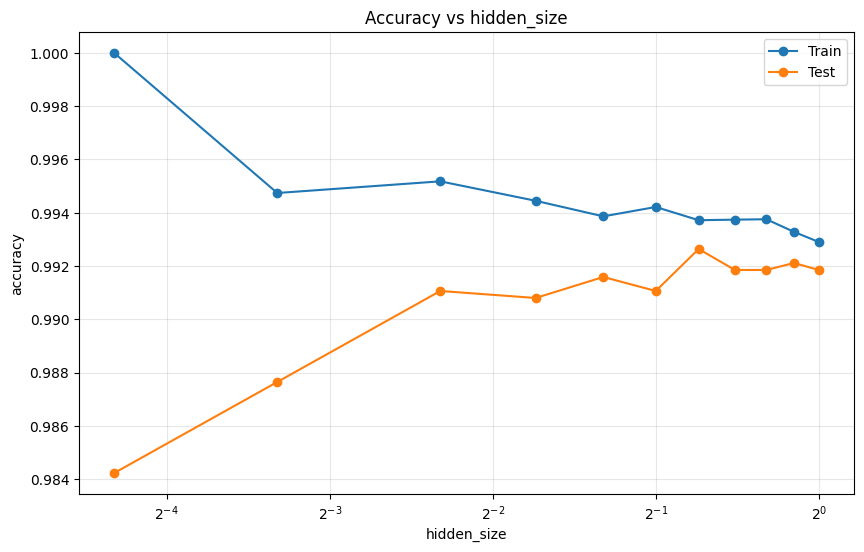

In [112]:
plot_accuracy(sample_results_df.rename(columns={'sample_size': 'hidden_size'}))

In [113]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

model.eval()

with torch.no_grad():
    logits = model(X_test_tensor)
    probs = torch.sigmoid(logits)
    predictions = (probs > 0.5).float()

# Convertir predictions i ground truth a numpy arrays
y_pred = predictions.numpy().flatten()
y_true = y_test_tensor.numpy().flatten()

# Calcular mètriques
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, probs.numpy().flatten())
cm = confusion_matrix(y_true, y_pred)

# Mostrar resultats
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"\nConfusion Matrix:\n{cm}")

Accuracy:  0.9995
Precision: 0.9993
Recall:    0.9993
F1-Score:  0.9993
ROC-AUC:   1.0000

Confusion Matrix:
[[2465    1]
 [   1 1337]]
